# Fictitious Play

In [1]:
using Games
using Distributions
using StatsBase
using Plots
import PyPlot
using StatsPlots

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


## Fictitious Play

### Coordination game

In [2]:
coordination_game_matrix = [4 0; 3 2]
g_Coo = NormalFormGame(coordination_game_matrix)
risk_dominant_action = argmax(vec(sum(coordination_game_matrix, dims=2)))
risk_dominated_action = 3 - risk_dominant_action;

In [3]:
fp_Coo = FictitiousPlay(g_Coo);

Generate a time series (with a random initial condition):

In [4]:
T = 100
paths = time_series(fp_Coo, T)

([0.625773 0.312887 … 0.00632094 0.00625773; 0.374227 0.687113 … 0.993679 0.993742], [0.102723 0.0513615 … 0.00103761 0.00102723; 0.897277 0.948639 … 0.998962 0.998973])

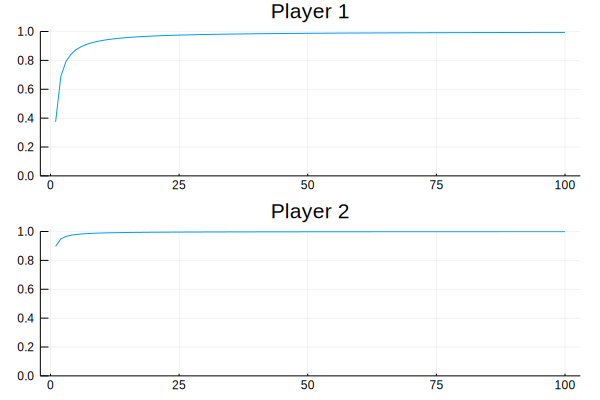

In [5]:
plts = [plot(path[risk_dominant_action, :], ylims=(0, 1), title="Player $i") for (i, path) in enumerate(paths)]
plot(plts..., layout=(2, 1), legend=false)

### Shapley game

In [6]:
p1 = Player([1 0 0; 0 1 0; 0 0 1])
p2 = Player([0 1 0; 0 0 1; 1 0 0])
g_Shapley = NormalFormGame(p1, p2)
fp_Shapley = FictitiousPlay(g_Shapley);

In [7]:
T = 250
init_actions = (1, 3)
paths = time_series(fp_Shapley, T, init_actions);

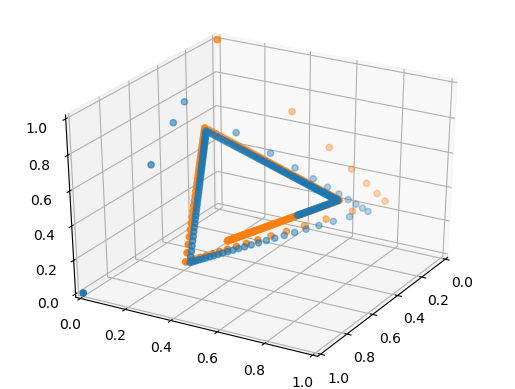

In [8]:
ax = PyPlot.subplot(111, projection="3d")
colors = ["C0", "C1"]
for i in 1:2
    ax.scatter(paths[i][1, :], paths[i][2, :], paths[i][3, :], c=colors[i])
end
for prop in [:set_xlim, :set_ylim, :set_zlim]
    getproperty(ax, prop)((0, 1))
end
ax.view_init(ax.elev, ax.azim+90)

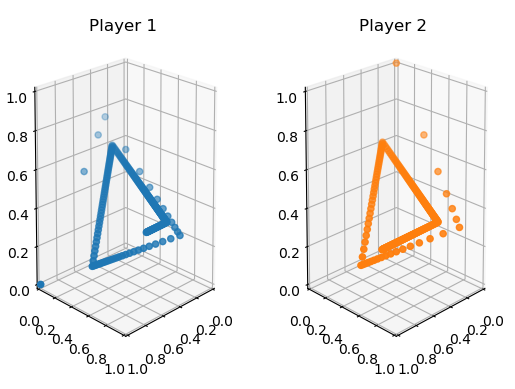

In [9]:
fig = PyPlot.figure()
for i in 1:2
    ax = fig.add_subplot(1, 2, i, projection="3d")
    ax.scatter(paths[i][1, :], paths[i][2, :], paths[i][3, :], c=colors[i])
    for prop in [:set_xlim, :set_ylim, :set_zlim]
        getproperty(ax, prop)((0, 1))
    end
    ax.view_init(ax.elev-15, ax.azim+105)
    ax.set_title("Player $i")
end

## Stochastic Fictitious Play

### Shapley game

In [10]:
sfp_Shapley = StochasticFictitiousPlay(g_Shapley, Normal(0, 0.08), ConstantGain(0.01));

In [11]:
T = 500
init_actions = fill.((1/3, 1/3), (3,))
paths = time_series(sfp_Shapley, T, init_actions);

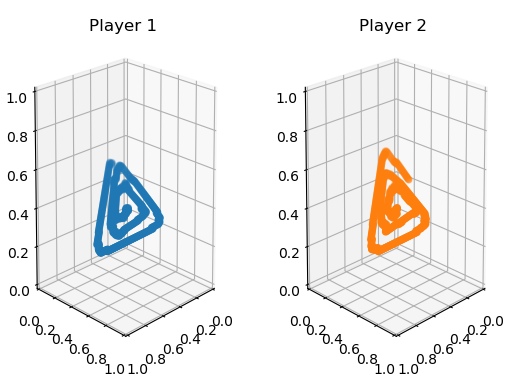

In [12]:
fig = PyPlot.figure()
for i in 1:2
    ax = fig.add_subplot(1, 2, i, projection="3d")
    ax.scatter(paths[i][1, :], paths[i][2, :], paths[i][3, :], c=colors[i])
    for prop in [:set_xlim, :set_ylim, :set_zlim]
        getproperty(ax, prop)((0, 1))
    end
    ax.view_init(ax.elev-15, ax.azim+105)
    ax.set_title("Player $i")
end

### Coordination game

In [13]:
sfp_Coo = StochasticFictitiousPlay(g_Coo, Normal(0, 0.33), ConstantGain(0.1));

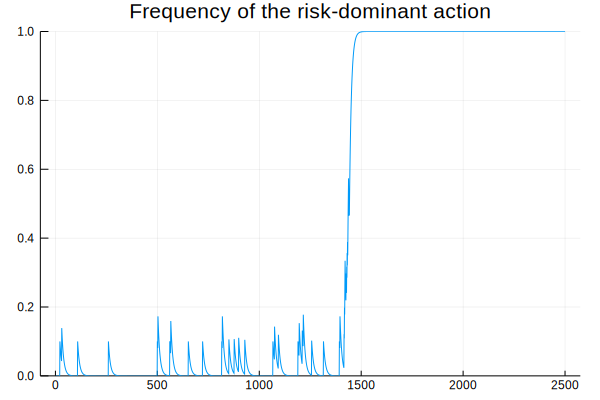

In [14]:
T = 2500
init_actions = (risk_dominated_action, risk_dominated_action)
paths = time_series(sfp_Coo, T, init_actions)
plot(paths[1][risk_dominant_action, :], ylims=(0, 1),
     legend=false, title="Frequency of the risk-dominant action")

In [15]:
sfp_Coo = StochasticFictitiousPlay(sfp_Coo, Normal(0, 1));

In [16]:
n_samples = 1000
periods = [100, 1000]
freqs = Array{Float64}(undef, n_samples, length(periods))
actions = Vector{Float64}.(undef, sfp_Coo.nums_actions)
for i in 1:n_samples
    for action in actions
        action[:] = pure2mixed(length(action), risk_dominated_action)
    end
    j = 1
    for t in 1:periods[end]
        if t == periods[j]
            freqs[i, j] = actions[1][risk_dominant_action]
            j += 1
        end
        play!(sfp_Coo, actions)
    end
end

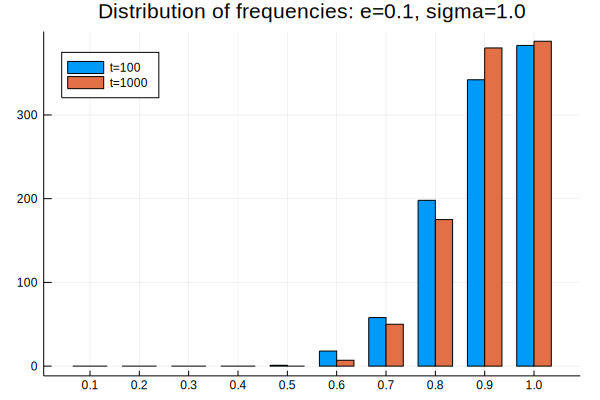

In [17]:
edges = 0:0.1:1
hs = Matrix{Int}(undef, length(edges)-1, length(periods))
for i in eachindex(periods)
    hs[:, i] = fit(Histogram, freqs[:, i], edges).weights
end

ctg = repeat(["t=$t" for t in periods], inner = 10)
nam = repeat(edges[2:end], outer = 2)
groupedbar(nam, hs, bar_position=:dodge, bar_width=0.07, xticks=edges,
           legend=:topleft, group=ctg,
           title="Distribution of frequencies: e=$(sfp_Coo.gain.size), sigma=$(sfp_Coo.d.σ)")

### Young's example

In [18]:
g_Young = NormalFormGame([6 0 0; 5 7 5; 0 5 8])
g_Young.players[1]

3×3 Player{2,Int64}:
 6  0  0
 5  7  5
 0  5  8

In [19]:
sfp_Young = StochasticFictitiousPlay(g_Young, Normal(0, 0.8), ConstantGain(0.05));

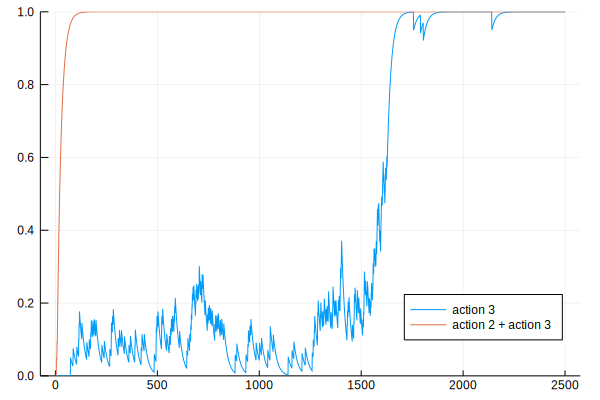

In [20]:
T = 2500
init_actions = (1, 1)
paths = time_series(sfp_Young, T, init_actions)
plot(paths[1][3, :], ylims=(0, 1), legend=:bottomright, label="action 3")
plot!(vec(sum(paths[1][[2, 3], :], dims=1)), label="action 2 + action 3")